In [1]:
import numpy as np
import custom_hd159062_lnlike as custom_lnlike
from orbitize import sampler,driver,kepler,system,results,lnlike
import multiprocessing as mp
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from astropy.time import Time
from datetime import datetime
import os

In [36]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=17)
plt.rc('axes', linewidth=1)

In [2]:
def M2tperi(M,P,tref):
    Tp = tref - M*P/(2*np.pi)
    return Tp #time of periastron from mean anomaly

def M2tau0(M,P,tref):
    Tp = M2tperi(M,P,tref)
    tau = Tp/P % 1
    return tau #tau from mean anomaly

def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P #fraction of orbit after tperi

def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0+m1))**(1/3) #sma in AU

def sma2p(sma,m0,m1):
    return (np.sqrt(sma**3/(m0 + m1)))*365.25 #period in days

In [3]:
#parameters for the white dwarf based on Lea's paper:
M = 144.0*np.pi/180
P = 238*365.25
wd_tref = 2452832.92

sma = p2sma(238*365.25,0.80,0.65)
ecc = 0.44
inc = 53.0*np.pi/180
argp = (-26+180)*np.pi/180
lan = (138.0+180)*np.pi/180
tau = M2tau0(M,P,wd_tref)
plx = 46.12
gamma = 934.0 #(in the K band)
sigma = 2.3 #(in the K band)
m1 = 0.65
m0 = 0.80

wd_params = [sma,ecc,inc,argp,lan,tau,plx,gamma,sigma,m1,m0]
print(wd_params)
print(M2tperi(M,P,wd_tref))
print('Period:', P)
print('Mean anomaly:',M)

[43.468431757814514, 0.44, 0.9250245035569946, 2.6878070480712677, 5.550147021341968, 0.8163468097711366, 46.12, 934.0, 2.3, 0.65, 0.8]
2418061.12
Period: 86929.5
Mean anomaly: 2.5132741228718345


In [4]:
chains = pd.read_csv('/Users/rtejada/Desktop/notebooks/HD159062/samp_0temp.csv')

In [5]:
chains['sma'] = p2sma(chains['per']*365.25,chains['m1'],chains['m2'])

In [6]:
chains['tau'] = M2tau0(chains['manom'],chains['per'],wd_tref)

In [7]:
param_cols = chains[['sma','ecc','inc','argp','lan','tau','para','off_j','jit_j','m2','m1']]

In [8]:
param_cols['argp'] = param_cols['argp'] % 2*np.pi

/Users/rtejada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
orbits_reshaped = np.reshape(param_cols.values.tolist(),(20,-1,11))

In [10]:
params_4poster = ['sma','e','i','$\omega$','$\Omega$','$\\tau$']

In [23]:
filename = '/Users/rtejada/Desktop/notebooks/HD159062/hd159062_mcmc.csv'

# system parameters
num_secondary_bodies = 1
system_mass = m0 # [Msol]
plx = plx # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.024 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 100
num_threads = mp.cpu_count() # or a different number if you prefer


my_mcmc = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0, 'gamma_bounds':(-5000, 5000), 'jitter_bounds':(1e-3, 50)},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input

In [24]:
m = my_mcmc.sampler
m.curr_pos = orbits_reshaped[:,:100,:]

In [25]:
m.custom_lnlike=custom_lnlike.m_and_sma_constraints

In [26]:
total_orbits = 500000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 100 # steps to burn in per walker
thin = 50# only save every 10th step

In [ ]:
today = datetime.now()
path = '/Users/rtejada/Desktop/'
param_names = ['sma','e','i','$\omega$','$\Omega$','$\\tau$','$\pi$','$\gamma$',
               '$\sigma$','M1','M0']

#change 'simuldata2' when running different data!!!

directory = path + 'HD159062_noclike_msmaconstraints/mcmcrun/' + today.strftime('%Y%m%d') + '/'
os.makedirs(directory)

for i in range(10):
    #running the sampler:
    m.run_sampler(total_orbits, burn_steps=0, thin=thin)
    chain = m.chain
    print('The chain shape is:',np.shape(chain))
    #saving each sampler chainL
    pkl_file = open(directory + 'mcmcchains_run%1d.txt' % i,'wb')
    pickle.dump(chain,pkl_file)
    
    #plotting and saving corner plots:
    corner_plot_fig = m.results.plot_corner(show_titles=True,
                                     quantiles=[0.16,0.5,0.84]) # Creates a corner plot and returns Figure object
    corner_plot_fig.savefig(directory + 'cornerplot%1d.pdf' % i)
    
    for j in range(15):
        with PdfPages(directory+'mcmc%1d_temps%1d.pdf' % (i,j)) as pdf:
            shape = np.shape(chain)
            num_steps = shape[2]
            num_params = shape[3]
            num_walkers = shape[1]
            for p in range(num_params):
                pname = param_names[p]
                fig = plt.figure(figsize = (8,5))
                for x in range(num_walkers):
                    #makes trend plot
                    plt.plot(range(num_steps),m.chain[j,x,:,p],alpha=0.7,linewidth=2)
                    plt.axhline(wd_params[p],ls='--',c='k')
                plt.ylabel(pname)
                plt.xlabel('steps')
                plt.minorticks_on()
                pdf.savefig()
                #plt.show()
                plt.close()
    print('Finished with %1d iterations!' % i)
                
flatchain = np.reshape(chain[0],(-1,11))
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,range=np.ones(len(param_names))*0.99,title_kwargs={"fontsize": 17})
corner_fig.savefig(directory + 'flatchain_cornerplot.pdf')

Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

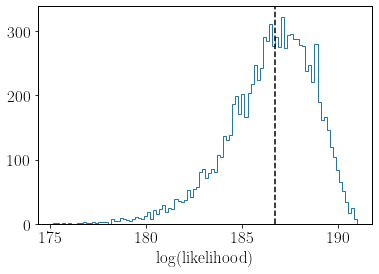

In [46]:
plt.hist(m.lnlikes,bins=100,histtype='step')
plt.axvline(x=np.median(m.lnlikes),c='k',ls='--')
plt.xlabel('$\log(\mathrm{likelihood})$')
plt.show()

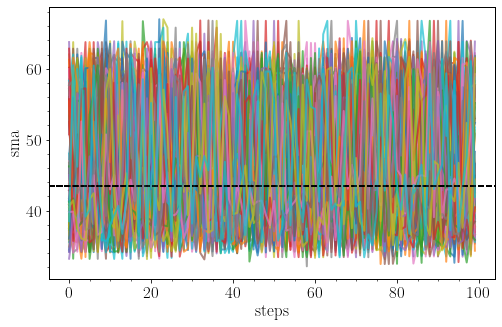

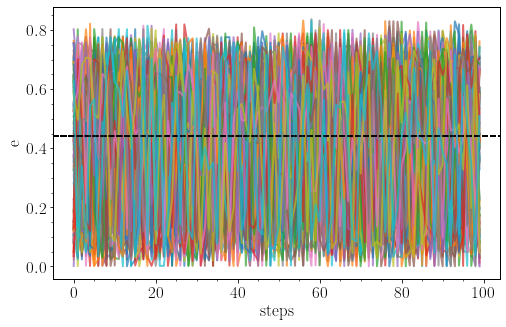

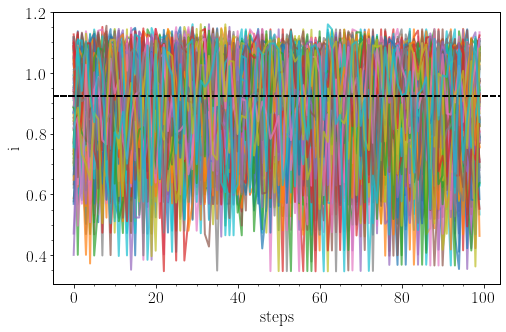

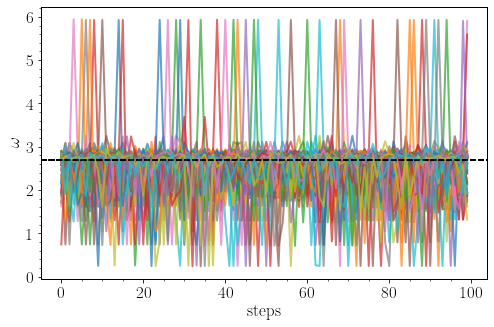

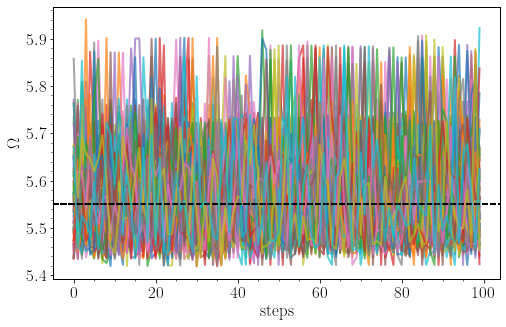

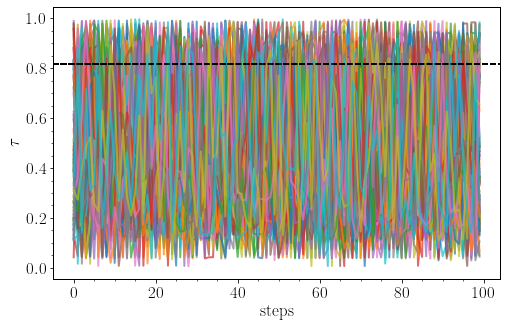

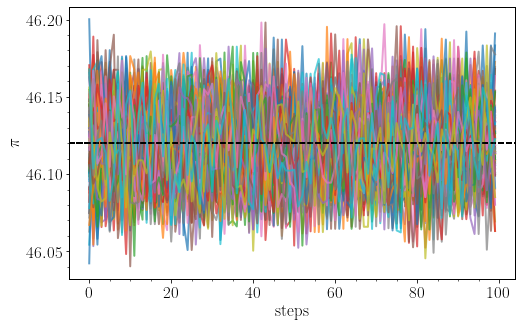

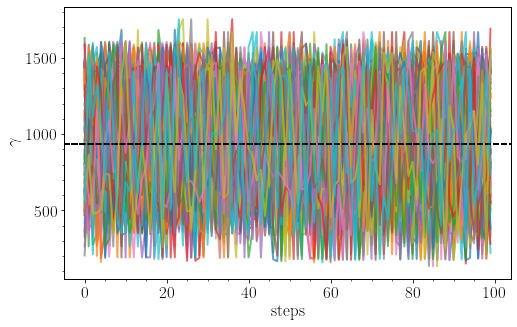

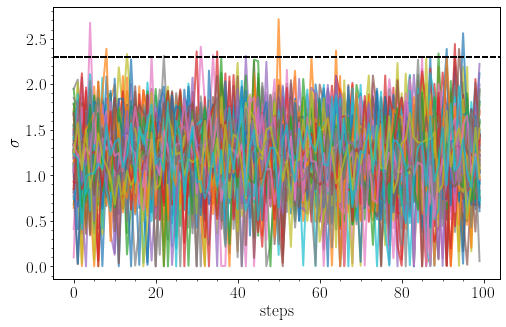

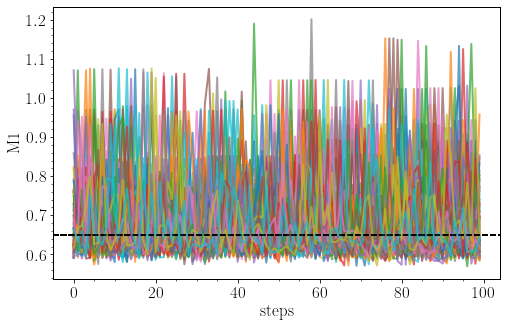

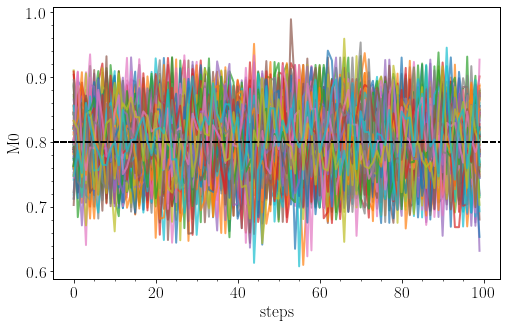

In [47]:
shape = np.shape(chain)
num_steps = shape[2]
num_params = shape[3]
num_walkers = shape[1]
for p in range(num_params):
    pname = param_names[p]
    fig = plt.figure(figsize = (8,5))
    for x in range(num_walkers):
        #makes trend plot
        plt.plot(range(num_steps),m.chain[0,x,:,p],alpha=0.7,linewidth=2)
        plt.axhline(wd_params[p],ls='--',c='k')
    plt.ylabel(pname)
    plt.xlabel('steps')
    plt.minorticks_on()
    plt.show()

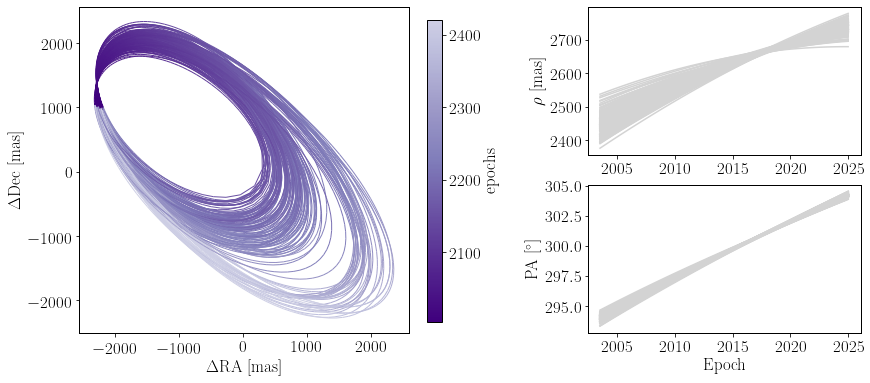

In [48]:
epochs = my_mcmc.system.data_table['epoch']

orbit_figure = m.results.plot_orbits(
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    num_orbits_to_plot=150
)
ax_orb, ax_cbar, ax_sep, ax_pa  = orbit_figure.axes

In [49]:
epochs_yr = Time(epochs, format='mjd').decimalyear
sep = my_mcmc.system.data_table['quant1'] ; sep_err = my_mcmc.system.data_table['quant1_err']
pa = my_mcmc.system.data_table['quant2'] ; pa_err = my_mcmc.system.data_table['quant2_err']

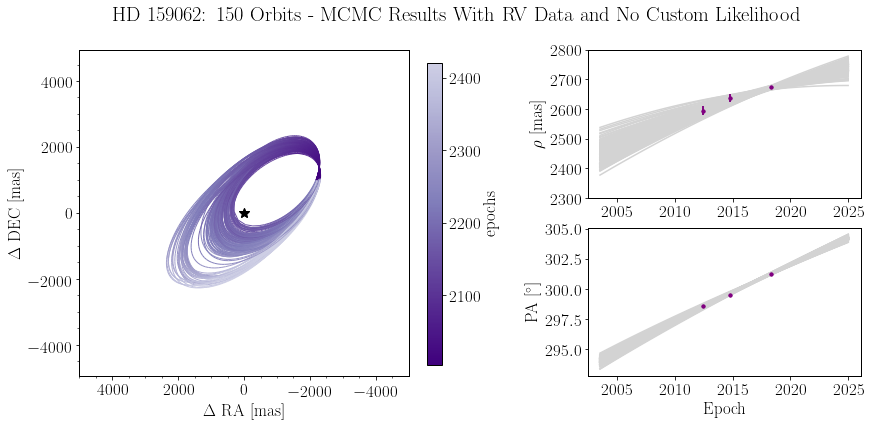

In [51]:
orbit_figure.suptitle('HD 159062: 150 Orbits - MCMC Results With RV Data and No Custom Likelihood')
ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_orb.set_xlabel('$\Delta$ RA [mas]')
ax_orb.set_ylabel('$\Delta$ DEC [mas]')
ax_orb.set_xlim(-5000,5000)
ax_orb.set_ylim(-5000,5000)
ax_sep.set_ylim(2300,2800)
ax_orb.minorticks_on()
ax_orb.invert_xaxis()
ax_pa.errorbar(epochs_yr,pa,pa_err,color='purple',linestyle='',fmt='.',zorder=3)
ax_sep.errorbar(epochs_yr,sep,sep_err,color='purple',linestyle='',fmt='.',zorder=3)
orbit_figure
#orbit_figure.savefig('/Users/rtejada/Desktop/HD159062_orbitplot_4poster_mcmc_wrvdata_noclike.pdf')